# Downloads


In [ ]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.7).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
!pip install gym # need Python 3.5+

In [ ]:
pip install --ignore-installed pip 

  Using cached pip-20.2.4-py2.py3-none-any.whl (1.5 MB)


In [ ]:
pip install gym[all]

  Using cached mujoco-py-1.50.1.68.tar.gz (120 kB)
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-z6wtvx4v/mujoco-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-z6wtvx4v/mujoco-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-azkbpy_i/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.6/mujoco-py Check the logs for full command output.


In [ ]:
!pip3 install box2d-py

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
pip install gym[classic_control]

In [ ]:
pip install pyglet

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


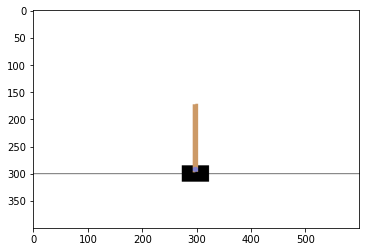

In [ ]:
import gym
import pyglet
env = gym.make('CartPole-v1') #The system is controlled by applying a force of +1 or -1 to the cart, and the goal is to prevent the pole from falling over.
env.reset()
plt.imshow(env.render('rgb_array'))
print(env.action_space)
print(env.observation_space)

# DQN

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
    super(DeepQNetwork, self).__init__()
    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.n_actions = n_actions

    self.fc1 = nn.Linear(input_dims,self.fc1_dims)
    self.fc1.weight.data.normal_(0, 0.1)
    self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
    self.fc2.weight.data.normal_(0, 0.1)
    self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
    self.fc3.weight.data.normal_(0, 0.1)
    
    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
      layer1 = F.relu(self.fc1(state.float()))
      layer2 = F.relu(self.fc2(layer1))
      actions = self.fc3(layer2)

      return actions

In [ ]:
class QlearningAgent:
    # def __init__(self, env,epsilon=1.0,lr=0.6,gamma=0.9):
    def __init__(self, env,input_dims,n_actions,epsilon=1.0,lr=0.6,gamma=0.9,batch_size=32,
                 max_mem_size=2000,C=100,fc_d1=8,fc_d2=16):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        # q_table_dim = env.table_dim

        # self.q_table = np.zeros((q_table_dim,q_table_dim,env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

        self.batch_size = batch_size
        self.max_mem_size=max_mem_size
        self.tracker = 0

        self.Q_eval = DeepQNetwork(lr=self.lr,input_dims=input_dims,n_actions=self.action_space.n,fc1_dims=fc_d1,fc2_dims=fc_d2) #change
        self.Q_eval_hat = DeepQNetwork(lr=self.lr,input_dims=input_dims,n_actions=self.action_space.n,fc1_dims=fc_d1,fc2_dims=fc_d2) #change
        
        self.Q_eval_hat.load_state_dict(self.Q_eval.state_dict())
        
        self.cnt=0

        self.state_memory = np.zeros((self.max_mem_size,input_dims),dtype=np.float)
        self.new_state_memory = np.zeros((self.max_mem_size,input_dims),dtype=np.float)

        self.action_memory = np.zeros(self.max_mem_size, dtype=np.float)
        self.reward_memory = np.zeros(self.max_mem_size, dtype=np.float)
        self.terminal_memory = np.zeros(self.max_mem_size, dtype=np.bool)

        self.C = C

    def step(self,observation):

      if random.uniform(0,1)<self.epsilon:
        action = np.random.choice(self.action_space.n)
        return action
      else:
      #  Ask Neural Network
        state = T.tensor([observation]).to(self.Q_eval.device)
        x = self.Q_eval.forward(state)
        # return np.argmax(self.q_table[int(observation[0]),int(observation[1])])
        return int(T.argmax(x))
    
    def store(self,state,action,reward,next_state,done):
     # Storing Code starts
      index = self.cnt%self.max_mem_size

      self.state_memory[index] = state
      self.new_state_memory[index] = next_state
      self.action_memory[index] = action
      self.reward_memory[index] = reward
      self.terminal_memory[index] = done
      # Storing Code Ends
    def setEpsilon(self,epsilon):
      self.epsilon = epsilon

    def learn(self):
          #New Code Starts

      self.cnt+=1
      if self.cnt<self.batch_size:
        return
      mem = min(self.cnt,self.max_mem_size)
      batch = np.random.choice(mem,self.batch_size,replace=False)
      
      batch_index = np.arange(self.batch_size, dtype=np.int32)

      state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
      new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
      action_batch = self.action_memory[batch]
      reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
      terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)


      q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch].to(self.Q_eval.device,dtype=T.float)
      q_next = self.Q_eval.forward(new_state_batch)
      q_next[terminal_batch] = 0.0


      q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0].to(self.Q_eval.device,dtype=T.float)
      q_target = q_target.detach()
      loss = self.Q_eval.loss( q_eval,q_target.float()).to(self.Q_eval.device)

      self.Q_eval.optimizer.zero_grad()
      loss.backward()
      self.Q_eval.optimizer.step()
    
      if self.cnt%self.C==0:
        self.Q_eval_hat.load_state_dict(self.Q_eval.state_dict())
      
      return loss
      # self.Q_eval.load_state_dict(self.Q_eval_hat.state_dict())


0


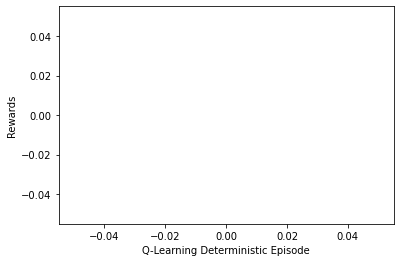

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


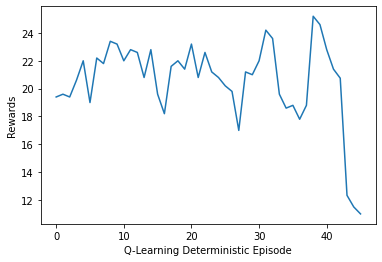

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


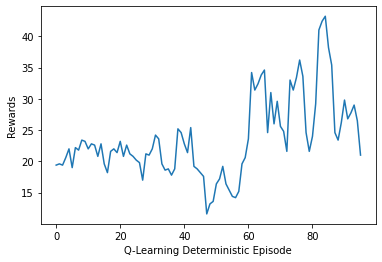

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


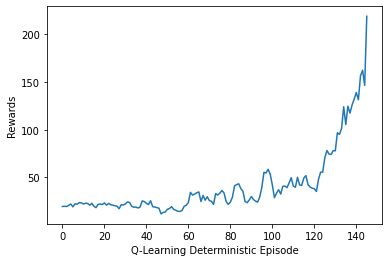

151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


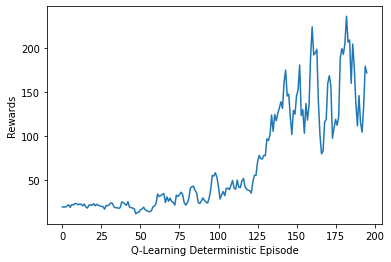

201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


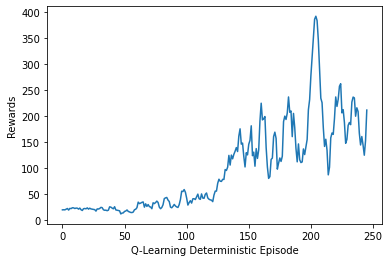

251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300


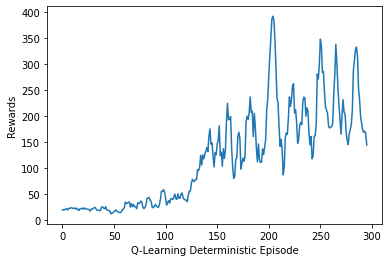

301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350


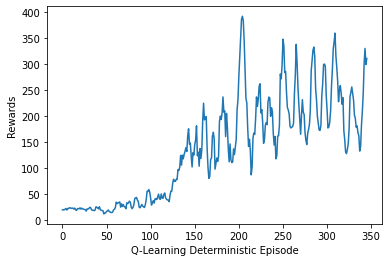

351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


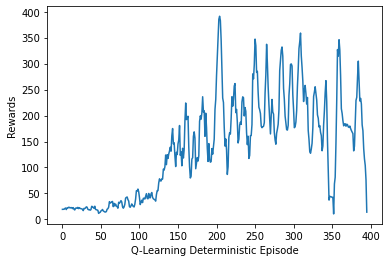

401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450


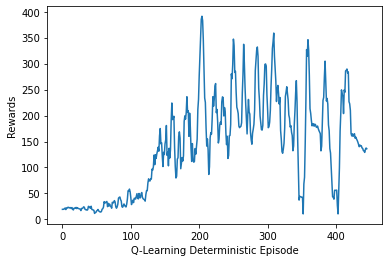

451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499


In [ ]:
# setting up environment and agent
import gym
env = gym.make('CartPole-v1') 
env.reset()

agent = QlearningAgent(env=env,input_dims=4,n_actions=2,epsilon=1.0,lr=0.001
                       ,gamma=0.95,batch_size=32,max_mem_size=1000,C=100,fc_d1=8,fc_d2=16)
episodes = 500
min_epsilon = 0.001

q_d_epsilons = []

q_d_rewards = []

q_d_loss=[]


for episode in range(episodes):
  print(episode)
  obs = env.reset()
  done = False
  q_d_epsilons.append(agent.epsilon)

  curr_reward = 0

  while not done:
    action = agent.step(obs)
    state = np.copy(obs)
    obs, reward, done, info = env.step(action)
    curr_reward+=reward
    next_state = np.copy(obs)
    agent.store(state,action,reward,next_state,done)
    loss = agent.learn()
    if loss:
      q_d_loss.append(loss.item())
  q_d_rewards.append(curr_reward)
  epsilon = max(min_epsilon,agent.epsilon*0.996)
  agent.setEpsilon(epsilon)
  if not episode%50:
    window = 5
    plt.xlabel('Q-Learning Deterministic Episode')
    plt.ylabel('Rewards')
    plt.plot([np.mean(q_d_rewards[tr:tr+window]) for tr in range(window, len(q_d_rewards))])
    plt.show()


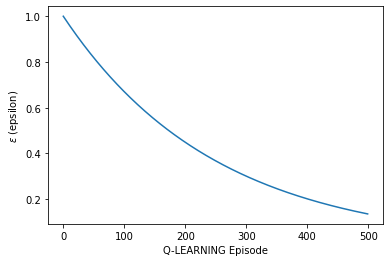

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('Q-LEARNING Episode')
plt.ylabel('$\epsilon$ (epsilon)')
plt.plot(q_d_epsilons)

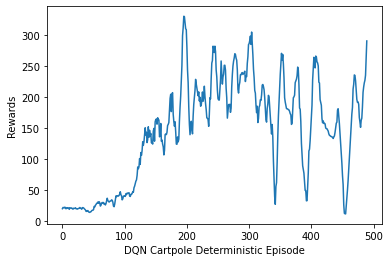

In [ ]:
window = 10
plt.xlabel('DQN Cartpole Deterministic Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_d_rewards[tr:tr+window]) for tr in range(window, len(q_d_rewards))])

In [ ]:
window = 10
plt.xlabel('Q-Learning Deterministic Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_d_loss[tr:tr+window]) for tr in range(window, len(q_d_loss))])

In [ ]:
env = gym.make('CartPole-v1')

obs = env.reset()
done = False
agent.epsilon = 0
# plt.imshow(env.render('rgb_array'))



while not done:
    action = agent.step(obs)
    print(action)
    obs, reward, done, info = env.step(action)
    print(reward)
    print(obs)
    # plt.imshow(env.render('rgb_array'))

0
1.0
[ 0.0178851  -0.2181358  -0.01344201  0.3127382 ]
0
1.0
[ 0.01352238 -0.4130637  -0.00718725  0.6011518 ]
0
1.0
[ 0.00526111 -0.60808438  0.00483579  0.89156223]
0
1.0
[-0.00690058 -0.80327159  0.02266703  1.18576135]
0
1.0
[-0.02296601 -0.99868008  0.04638226  1.48546231]
0
1.0
[-0.04293961 -1.19433567  0.0760915   1.79226157]
0
1.0
[-0.06682633 -1.39022362  0.11193674  2.10759259]
0
1.0
[-0.0946308  -1.58627446  0.15408859  2.43266913]
0
1.0
[-0.12635629 -1.78234738  0.20274197  2.76841684]
1
1.0
[-0.16200324 -1.58912168  0.25811031  2.54371335]


In [ ]:
q_dqn_rewards = q_d_rewards